In [1]:
#https://motius.breezy.hr/p/0b622aa1163e01-join-our-tech-community-as-working-student-m-f-d/apply?utm_source=pt-linkedin&utm_medium=job-posting

In [2]:
"""!pip install datasets
!pip install transformers
!pip install sentence_transformers
!pip install peft
!pip install huggingface_hub
!pip install --upgrade accelerate
!pip install --upgrade bitsandbytes
!pip install --upgrade torchmetrics
!pip install --upgrade deepspeed
"""

'!pip install datasets\n!pip install transformers\n!pip install sentence_transformers\n!pip install peft\n!pip install huggingface_hub\n!pip install --upgrade accelerate\n!pip install --upgrade bitsandbytes\n!pip install --upgrade torchmetrics\n!pip install --upgrade deepspeed\n'

In [3]:
from transformers import  AutoModel,AutoTokenizer,AutoModelForMaskedLM , Trainer,TrainingArguments,\
BitsAndBytesConfig,pipeline,default_data_collator,DataCollatorWithPadding,DataCollatorForLanguageModeling
from transformers.utils import move_cache
#from chat_template_utils import get_json_schema
#from llama_cpp import Llama
from utils import *
from peft import *
import datasets
#import torchmetrics
import torch
from torch.utils.data.dataloader import DataLoader,Dataset
#from hqq.engine.hf import HQQModelForCausalLM
#from hqq.models.hf.base import AutoHQQHFModel
from huggingface_hub import snapshot_download
#import deepspeed
import os
import pandas as pd
import json
#from var_dump import var_dump
from bs4 import BeautifulSoup,PageElement,Comment
import matplotlib.pyplot as plt
import seaborn as sns

cache_dir='/var/tmp/.cache/' #'/proj/ciptmp/ix05ogym/.cache/'
output_dir = cache_dir+'outputs/'

move_cache(cache_dir)

def pd_full_screen():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    
def pd_normal_screen():
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', 5)


No ROCm runtime is found, using ROCM_HOME='/usr'
/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


0it [00:00, ?it/s]

In [4]:
with open('result.json','r',encoding='utf-8') as file:
    
    j = file.read()
    j = json.loads(j)
    print(j.keys())
    

dict_keys(['name', 'type', 'id', 'messages'])


In [5]:
#j['messages'][1]['from']
#datasets.Dataset.from_json('result.json',field="messages")
df = pd.read_json('result.json')


info_df = pd.json_normalize(df['messages'])[['from','text']]

#joined = info_df['from']+': '+info_df['text']
info_df = info_df[~(info_df['text']=='')].dropna().reset_index(drop=True)
#info_df[~(info_df['from']=='')]

info_df

,from,text
0,مجید,خب من دیروز ساعت 9وربع رسیدم خونه :)
1,مسعود شرقی,Salam
2,مسعود شرقی,Hfhgghg
3,مسعود شرقی,Hfgghfggfggggggfgv
4,مجید,Hh
...,...,...
32501,مسعود شرقی,این چتها که فرستادی رو میگی؟
32502,مسعود شرقی,اخرش گفتی دوتا ویدئو فرستاد و پاک کرد من تا هم...
32503,مجید,ولش کون
32504,مسعود شرقی,اره خوندم خوب بود نکته ای نبود که بخام بگم.همی...


In [6]:
c = info_df['text'].str.contains("\[",na=True)
x = info_df.loc[c,:].reset_index()
x

,index,from,text
0,7,مجید,[بخشی از سهام شرکت سرمایه‌گذاری «دیجی‌کالا» و ...
1,12,مسعود شرقی,[پس از مدت ها سعی و تلاش شبانه روزی توانستیم ت...
2,13,مسعود شرقی,[پس از مدت ها سعی و تلاش شبانه روزی توانستیم ت...
3,30,مسعود شرقی,"[{'type': 'link', 'text': 'http://btab.ir/'}]"
4,35,مجید,[💢 گیف شمارۀ 116:\nچطور تخم مرغ رو بندازیم توی...
...,...,...,...
653,31505,مجید,"[{'type': 'link', 'text': 'https://youtube.com..."
654,31606,مجید,"[{'type': 'link', 'text': 'https://youtube.com..."
655,31731,مجید,"[{'type': 'custom_emoji', 'text': '💎', 'docume..."
656,31798,مجید,"[{'type': 'link', 'text': 'https://autoapply.j..."


In [7]:
print(x.loc[0,'text'])

['بخشی از سهام شرکت سرمایه\u200cگذاری «دیجی\u200cکالا» و «کافه بازار»  به ارزش حدود ۶ میلیون و ۴۰۰ هزار یورو توسط یک «شرکتی سوئدی» خریداری شده است.\n', {'type': 'mention', 'text': '@manototv'}, '']


In [8]:
c1 = info_df['from']=='مسعود شرقی'
c2 = info_df['from'] == 'مجید'
info_df[~( c1 | c2 )]

,from,text


In [9]:
def get_one_msg(x):
    text = x['text']
    if not isinstance(text,str):
        #print(text[0])
        return pd.NA
    
    return  { 
     "role":x['from'],
     "content": text
    }
    
data = info_df.apply(get_one_msg,axis=1)
data = data.dropna()
data

0        {'role': 'مجید', 'content': 'خب من دیروز ساعت ...
1               {'role': 'مسعود شرقی', 'content': 'Salam'}
2             {'role': 'مسعود شرقی', 'content': 'Hfhgghg'}
3        {'role': 'مسعود شرقی', 'content': 'Hfgghfggfgg...
4                        {'role': 'مجید', 'content': 'Hh'}
                               ...                        
32501    {'role': 'مسعود شرقی', 'content': 'این چتها که...
32502    {'role': 'مسعود شرقی', 'content': 'اخرش گفتی د...
32503               {'role': 'مجید', 'content': 'ولش کون'}
32504    {'role': 'مسعود شرقی', 'content': 'اره خوندم خ...
32505    {'role': 'مسعود شرقی', 'content': 'حالا یه کم ...
Length: 31853, dtype: object

In [10]:
from transformers import Qwen2ForCausalLM,T5ForConditionalGeneration
device = 'cuda'
model_name = 'Qwen/Qwen2-0.5B-Instruct'
#model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name,cache_dir=cache_dir)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:

model = Qwen2ForCausalLM.from_pretrained(model_name #Qwen/Qwen2-0.5B-Instruct
                                         #,attn_implementation="flash_attention_2"
                                         #,torch_dtype=torch.float16
                                         , device_map='auto',cache_dir=cache_dir).to('cuda')

model.eval()
#model.config['use_sliding_window']=True
print(model.config)

model

Qwen2Config {
  "_name_or_path": "Qwen/Qwen2-0.5B-Instruct",
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "use_sliding_window": false,
  "vocab_size": 151936
}



Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_head): Linear(in_featur

In [12]:
windows_size = 21
train_dataset = []
for i in range(0,len(data)-windows_size,windows_size-7):
    d = [{"role":"system","content":"زبان شما فارسی است."}]
    d.extend( data[i:i+windows_size].tolist() )
    train_dataset.append(d)
    
train_dataset


[[{'role': 'system', 'content': 'زبان شما فارسی است.'},
  {'role': 'مجید', 'content': 'خب من دیروز ساعت 9وربع رسیدم خونه :)'},
  {'role': 'مسعود شرقی', 'content': 'Salam'},
  {'role': 'مسعود شرقی', 'content': 'Hfhgghg'},
  {'role': 'مسعود شرقی', 'content': 'Hfgghfggfggggggfgv'},
  {'role': 'مجید', 'content': 'Hh'},
  {'role': 'مسعود شرقی', 'content': 'Hggg'},
  {'role': 'مجید', 'content': ':|'},
  {'role': 'مجید',
   'content': 'ببخشید عاقا میتونم بخشی از سهام لوکس بلاگو بخرم؟'},
  {'role': 'مجید', 'content': '😑'},
  {'role': 'مسعود شرقی', 'content': 'متاسفانه فروخته شده به گوگل.نمیدونستی؟'},
  {'role': 'مجید', 'content': 'عخییییییی'},
  {'role': 'مسعود شرقی', 'content': 'سلام هسی؟'},
  {'role': 'مجید', 'content': 'هان؟'},
  {'role': 'مجید', 'content': 'هااااان؟'},
  {'role': 'مسعود شرقی', 'content': 'به مامان بگو فردا شب بریم خونه جون جون'},
  {'role': 'مسعود شرقی', 'content': 'ما فردا شب هستیم'},
  {'role': 'مجید', 'content': 'ساعت یکه :|'},
  {'role': 'مجید', 'content': 'فردا نمیری 

In [13]:
tokenized_train_data= tokenizer.apply_chat_template(train_dataset,truncation=True,max_length=512)


In [14]:
l = []
for i in range(len(tokenized_train_data)):
    l.append(len(tokenized_train_data[i]))
    

l

[351,
 416,
 432,
 430,
 375,
 397,
 512,
 512,
 386,
 420,
 405,
 487,
 386,
 405,
 376,
 370,
 512,
 403,
 327,
 283,
 406,
 396,
 447,
 434,
 415,
 512,
 512,
 316,
 369,
 366,
 329,
 323,
 355,
 352,
 356,
 339,
 358,
 364,
 304,
 374,
 355,
 377,
 337,
 469,
 456,
 450,
 330,
 365,
 329,
 408,
 405,
 258,
 208,
 348,
 509,
 348,
 378,
 361,
 355,
 342,
 350,
 442,
 506,
 323,
 259,
 416,
 377,
 258,
 309,
 373,
 373,
 493,
 384,
 313,
 292,
 307,
 459,
 341,
 336,
 403,
 431,
 430,
 420,
 375,
 352,
 382,
 497,
 432,
 462,
 383,
 371,
 332,
 394,
 313,
 291,
 292,
 502,
 294,
 397,
 443,
 401,
 404,
 479,
 397,
 427,
 349,
 359,
 336,
 338,
 356,
 444,
 440,
 448,
 414,
 445,
 487,
 408,
 320,
 387,
 413,
 512,
 486,
 436,
 436,
 505,
 383,
 512,
 512,
 508,
 484,
 372,
 371,
 439,
 448,
 416,
 436,
 398,
 308,
 306,
 425,
 499,
 464,
 494,
 512,
 491,
 332,
 286,
 321,
 366,
 330,
 512,
 512,
 460,
 365,
 331,
 490,
 371,
 404,
 446,
 370,
 373,
 420,
 431,
 321,
 306,
 351,
 376

                 0
count  2274.000000
mean    421.410730
std      64.488997
min     208.000000
25%     371.000000
50%     418.000000
75%     478.000000
max     512.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

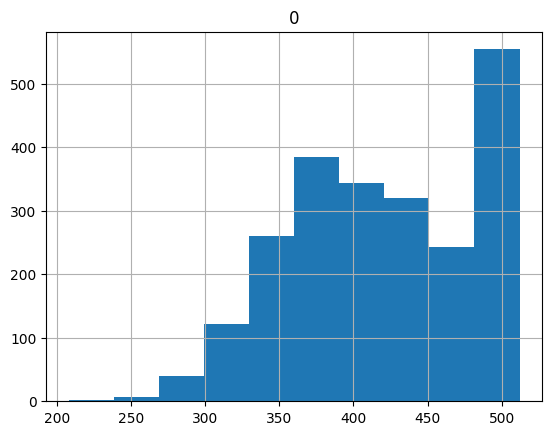

In [15]:
l = pd.DataFrame.from_dict(l)
print(l.describe())
l.hist()

In [16]:
tokenizer.decode( tokenized_train_data[0] )

'<|im_start|>system\nزبان شما فارسی است.<|im_end|>\n<|im_start|>مجید\nخب من دیروز ساعت 9وربع رسیدم خونه :)<|im_end|>\n<|im_start|>مسعود شرقی\nSalam<|im_end|>\n<|im_start|>مسعود شرقی\nHfhgghg<|im_end|>\n<|im_start|>مسعود شرقی\nHfgghfggfggggggfgv<|im_end|>\n<|im_start|>مجید\nHh<|im_end|>\n<|im_start|>مسعود شرقی\nHggg<|im_end|>\n<|im_start|>مجید\n:|<|im_end|>\n<|im_start|>مجید\nببخشید عاقا میتونم بخشی از سهام لوکس بلاگو بخرم؟<|im_end|>\n<|im_start|>مجید\n😑<|im_end|>\n<|im_start|>مسعود شرقی\nمتاسفانه فروخته شده به گوگل.نمیدونستی؟<|im_end|>\n<|im_start|>مجید\nعخییییییی<|im_end|>\n<|im_start|>مسعود شرقی\nسلام هسی؟<|im_end|>\n<|im_start|>مجید\nهان؟<|im_end|>\n<|im_start|>مجید\nهااااان؟<|im_end|>\n<|im_start|>مسعود شرقی\nبه مامان بگو فردا شب بریم خونه جون جون<|im_end|>\n<|im_start|>مسعود شرقی\nما فردا شب هستیم<|im_end|>\n<|im_start|>مجید\nساعت یکه :|<|im_end|>\n<|im_start|>مجید\nفردا نمیری سر کار مگه تو؟<|im_end|>\n<|im_start|>مجید\nبگیر بخاب<|im_end|>\n<|im_start|>مجید\nراسی<|im_end|>\n<|im_s

In [17]:
model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "pad_token_id": 151643,
  "repetition_penalty": 1.1,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

In [18]:
model = get_peft_model(model,LoraConfig(task_type=TaskType.CAUSAL_LM,target_modules=['q_proj','v_proj','k_proj',
                                                                                     'o_proj',
                                                                                     'lm_head',
                                                                                     'gate_proj','up_proj','down_proj']))
#model = get_peft_model(model,LoraConfig(task_type=TaskType.CAUSAL_LM,target_modules=['q','v','k']))

model.print_trainable_parameters()
model
for n,p in model.named_parameters():
    if p.requires_grad==False:
        print(n)

trainable params: 5,621,760 || all params: 499,654,528 || trainable%: 1.1251
base_model.model.model.embed_tokens.weight
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.q_proj.base_layer.bias
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.k_proj.base_layer.bias
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight
base_model.model.model.layers.0.self_attn.v_proj.base_layer.bias
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight
base_model.model.model.layers.0.mlp.gate_proj.base_layer.weight
base_model.model.model.layers.0.mlp.up_proj.base_layer.weight
base_model.model.model.layers.0.mlp.down_proj.base_layer.weight
base_model.model.model.layers.0.input_layernorm.weight
base_model.model.model.layers.0.post_attention_layernorm.weight
base_model.model.model.layers.1.self_attn.q_proj.base_layer.weight
base_model.model.model.layers.1.self_attn

In [19]:
print(tokenizer("<|im_start|>"))

{'input_ids': [151644], 'attention_mask': [1]}


In [20]:
mydc = DataCollatorForLanguageModeling(tokenizer,False)
def mmf(x):
    y = mydc(x)
    b = 1
    for i in range(len(y['labels'][0])-1,-1,-1  ):
        if y['labels'][0][i]==151644:
                b= i
                break

    for i in range(0,b):
        y['labels'][0][i]=-100
        pass
    return y

y = mmf(tokenized_train_data[0:1])
y



{'input_ids': tensor([[151644,   8948,    198,  39697, 130574,  52157, 124009,  45577,  35038,
           20064,  14391,  93153,     13, 151645,    198, 151644, 127641,  65043,
             198, 125940,  63237,  44330,  14391,  84996,  39697, 138717,  14293,
             220,     24,  58656, 124876, 127490,  65043,  10176,  74315, 123890,
           16157,  25956, 151645,    198, 151644, 124223, 124915,  52157, 128801,
           14391,    198,     50,  16823, 151645,    198, 151644, 124223, 124915,
           52157, 128801,  14391,    198,     39,  31104,     70,    866,     70,
          151645,    198, 151644, 124223, 124915,  52157, 128801,  14391,    198,
              39,   4817,    866,   4817,     70,   4817,  14398,  14398,     70,
            4817,     85, 151645,    198, 151644, 127641,  65043,    198,     39,
              71, 151645,    198, 151644, 124223, 124915,  52157, 128801,  14391,
             198,     39,  14398,     70, 151645,    198, 151644, 127641,  65043,
   

In [277]:
from transformers import TrainerCallback
"""
class ChangeDatasetCallback(TrainerCallback):
    def __init__(self):
        #super.__init__()
        pass

    def on_epoch_end(self, args, state, control, **kwargs):
        # Move to the next dataset at the end of each epoch
        #self.current_epoch += 1
        #new_dataset = self.datasets[self.current_epoch % len(self.datasets)]
        kwargs['train_dataloader'].dataset = get_train_data()
        #kwargs['eval_dataloader'].dataset = new_dataset['validation']
"""
"""
class custom_dataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.dataset = get_train_data()
        self.len = len(self.dataset)
        pass

    def __getitem__(self, i) :
        if i==self.len-1:
            self.dataset = get_train_data()

        return self.dataset[i]
        pass

    def __len__(self):
        return self.len
        pass
"""
trainer =  Trainer(model,
        train_dataset=tokenized_train_data,
        data_collator=mydc,
        #compute_metrics=compute_metric,
        #callbacks=[ChangeDatasetCallback()],
        tokenizer=tokenizer,
        args=TrainingArguments(
          output_dir=output_dir,
          num_train_epochs=5,
          per_device_train_batch_size=1,
          per_device_eval_batch_size=1,
          logging_steps=300,

          #eval_accumulation_steps =2,


        ))

trainer.train()
model = model.eval()

Step,Training Loss
300,0.756600
600,0.810400
900,0.827200
1200,0.847500
1500,0.838000
1800,0.849500
2100,0.860800
2400,0.809500
2700,0.731500
3000,0.737800


/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/peft/utils/save_and_load.py:180: UserWarnin

In [326]:
model.save_pretrained(output_dir+'/farsi5/')

/proj/ciptmp/ix05ogym/myenv/lib/python3.11/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [324]:
d =[
    {"role":"system","content":"زبان شما فارسی است."},
    #{"role":"مجید" ,"content":"خبی"},
    {"role":"مجید" ,"content":"بیکاری؟"},
    
    #{"role":"مجید" ,"content":"ببخشید عاقا میتونم بخشی از سهام لوکس بلاگو بخرم؟"},
    {"role":"مسعود شرقی" ,"content":""},
    
    
    
]
t = tokenizer.apply_chat_template(d,return_tensors='pt')[:,:-2].to('cuda')
#get_one_msg(d)
print(t)
print(tokenizer.decode(t[0]))
print('----------------------------------')
model.eval()
with torch.no_grad():
    o = model.generate(input_ids=t,min_new_tokens=0,max_new_tokens =1000,do_sample=True)#,stop_strings="<asa>?",tokenizer = tokenizer)
    print(tokenizer.decode(o[0]))


tensor([[151644,   8948,    198,  39697, 130574,  52157, 124009,  45577,  35038,
          20064,  14391,  93153,     13, 151645,    198, 151644, 127641,  65043,
            198,  21360,  14391,  32311,  35038,  14391, 128332, 151645,    198,
         151644, 124223, 124915,  52157, 128801,  14391,    198]],
       device='cuda:0')
<|im_start|>system
زبان شما فارسی است.<|im_end|>
<|im_start|>مجید
بیکاری؟<|im_end|>
<|im_start|>مسعود شرقی

----------------------------------
<|im_start|>system
زبان شما فارسی است.<|im_end|>
<|im_start|>مجید
بیکاری؟<|im_end|>
<|im_start|>مسعود شرقی
جواب نمیداد ولی کم میشه واسه گزینه ای دارم فردا انگلیسی خودممو بود رو یونابورو میداد.همه اینا متفاوته<|im_end|>


In [23]:
questions = [
"use html to create email"
,"""what is your gender?"""
,"""where are you living?(optional)"""
,"what is your salary expectation?*"
,"Which pronouns should we use to address you? (optional)"
,"how is your German?"
,"do you need visa spunsership?"
,"where are you working right now?"
,"what is your birth date?"
,"what are your hobbies?"
,"password"
,"what projects have you done?"
,"are you a text ai?"
,"what experice do you have in network engineering?"
,"what projects have you done in deep learning?"
,"how did you find us?"]

#model.disable_adapter()

x= [get_one_chat_template(""#person_to_str(person)
                          ,q+"""<input type="text" style="" id="custom">""") for q in questions]
tokenized_questions = tokenizer.apply_chat_template(x)

with torch.no_grad():
    
    for i,x in enumerate(tokenized_questions):
            x = torch.tensor([x]).to('cuda')
            o = model.generate(input_ids=x,max_new_tokens=500,do_sample=False)
            
            print(questions[i])
            #decoded = tokenizer.decode(o[0,x.shape[1]+3:])
            decoded = tokenizer.decode(o[0])
            
            print(decoded)
            print('--------------------------------------------------------')
        
    

NameError: name 'get_one_chat_template' is not defined

In [ ]:
model = model.to('cuda')
def get_answer(decoded):
    try:
                #print("ERROR: ",decoded)

                _s = decoded.find('{')
                _e = decoded.find('}',_s)+1
                #print(decoded[_s:_e])
                answer = json.loads(decoded[_s:_e])['answer']
                return answer
                
    except Exception as e:
                print("ERROR: ",e)
                print(decoded)
                print("---------------------------------")

                
def compute_metric():
    model.eval()
    acc=0
    with torch.no_grad():
        for i in range(len(no_label)):
            x = mydc([no_label[i]])['input_ids'].to('cuda')
            #print(x)
            o = model.generate(input_ids=x,max_new_tokens=20,do_sample=False)
            decoded = tokenizer.decode(o[0,x.shape[1]:])
            #print(decoded)
            #break

            #print(x[0],x[1])
            answer = get_answer(decoded)
            _label = test_dataset.loc[i,'label']
            #_label = person[test_dataset.loc[i,'label']]
            c = answer==_label

            if c:
                acc +=1
            else:
                print("NO_CORRECT:",answer,_label)
                print("---------------------------------")

                pass

    acc/=len(no_label)
    print("acc:",acc)



compute_metric()

In [ ]:
model.eval()
i =11
d = mydc(no_label[i:i+1])['input_ids'].to(device)
d = tokenizer.apply_chat_template( [#{"role":"system","content":""}
                             {"role":"user", "content":"""Your answer has to be in json format like {"answer":""}. Use this content in your answer:\n"""+s}
                            ,{"role":"user", "content":'email'}] , return_tensors='pt').to(device)
#d = tokenizer(['json {"answer":""} what is this html element about? <input type="email">'],return_tensors='pt')['input_ids'].to(device)
#print(d)
with torch.no_grad():

    o = model.generate(input_ids = d,max_length = 512,do_sample=True)
    print(tokenizer.decode(o[0]))



In [ ]:
"""x =Qwen2ForCausalLM.from_pretrained('Qwen/Qwen2-0.5B-Instruct',cache_dir=cache_dir)
model = PeftModelForCausalLM.from_pretrained(x,output_dir+'saved/')"""

In [325]:
output_dir

'/var/tmp/.cache/outputs/'